In [4]:
import random
import matplotlib.pyplot as plt
import networkx as nx

**The Plan**
- Define a super simple MDP. Start without any cycles, literally just make it a directed acyclic graph.
- Assign random numbers to all state-action pairs in this MDP (e.g. sampled from a gaussian with mean 0, variance 1), i.e. a maximally dense reward function.
- Write a function which computes the set of optimal policies assuming that those numbers are interpreted as a reward function.
- Generate many (e.g. 1000) random reward functions, and check that the optimal policies they lead to are non-uniform, i.e. some policies are more likely than others to be generated via this process.

Hypotheses: (speculative)
- Some policies will be more likely than others to be generated (what structure in particular?)

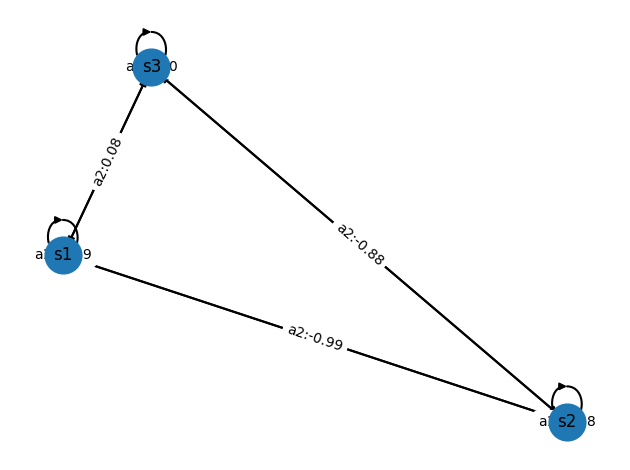

MDP Summary:
States: s1, s2, s3
Actions: a1, a2
Discount Factor: 0.9
Optimal Policy: {'s1': 'a2', 's2': 'a2', 's3': 'a1'}


In [35]:
### Defining a markov decision process
### Thanks ChatGPT (again)

import numpy as np

class MDP:
    def __init__(self, states, actions, transition_function, reward_function, gamma):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function  # Function: (s, a, s') -> Probability
        self.reward_function = reward_function  # Function: (s, a, s') -> Reward, now passed during initialization
        self.gamma = gamma

    def get_possible_actions(self, state):
        return self.actions

    def transition(self, state, action):
        return [(self.transition_function(state, action, next_state),
                 next_state,
                 self.reward_function(state, action, next_state))
                for next_state in self.states]

    def compute_optimal_policy(self, epsilon=0.01, max_iterations=1000):
        values = {state: 0 for state in self.states}
        policy = {state: None for state in self.states}

        for _ in range(max_iterations):
            delta = 0
            for state in self.states:
                v = values[state]
                action_values = [sum(p * (reward + self.gamma * values[next_state])
                                     for p, next_state, reward in self.transition(state, action))
                                 for action in self.get_possible_actions(state)]
                values[state] = max(action_values)
                delta = max(delta, abs(v - values[state]))
            if delta < epsilon:
                break

        for state in self.states:
            action_values = {action: sum(p * (reward + self.gamma * values[next_state])
                                          for p, next_state, reward in self.transition(state, action))
                             for action in self.get_possible_actions(state)}
            policy[state] = max(action_values, key=action_values.get)

        return policy

    def plot_graph(self):
        G = nx.MultiDiGraph()

        # Add nodes for each state
        for state in self.states:
            G.add_node(state)

        # Add edges for each action and transition
        for state in self.states:
            for action in self.actions:
                for next_state in self.states:
                    if self.transition_function(state, action, next_state) > 0:
                        reward = self.reward_function(state, action, next_state)
                        G.add_edge(state, next_state, action=action, weight=reward)

        # plt.figure(figsize=(12, 8))  # Increase the plot size
        pos = nx.spring_layout(G, k=0.5, iterations=20)  # k: Optimal distance between nodes. Increase/decrease to spread nodes out

        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_labels(G, pos)

        # Draw edges and add labels
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.5)

        edge_labels = {(u, v): f"{d['action']}:{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
        
        # Calculate edge label positions at the midpoint of the edges
        edge_label_pos = {edge: ((pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2) 
                        for edge in G.edges()}

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.axis('off')
        plt.tight_layout()  # Adjust layout to prevent cutting off edge labels
        plt.show()

    def __str__(self):
        states_str = ', '.join(self.states)
        actions_str = ', '.join(self.actions)
        return (f"MDP Summary:\n"
                f"States: {states_str}\n"
                f"Actions: {actions_str}\n"
                f"Discount Factor: {self.gamma}")


# Define a reward function that assigns random rewards for each state-action pair
def random_reward_function(states, actions):
    """Initializes a reward function that assigns random rewards to state-action pairs."""
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = np.random.normal(0, 1)  # Gaussian distribution, mean=0, variance=1
    # print(rewards)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

# Example MDP setup
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
def transition_function(s, a, s_prime): #simple function for demonstration
    if a == actions[0]:
        return 1 if s_prime == s else 0
    else:
        return 0 if s_prime == s else (1.0 / len(states))

gamma = 0.9 # Discount factor
# Create an MDP object with the randomized reward function

mdp = MDP(states, actions, transition_function, random_reward_function(states, actions), gamma)
optimal_policy = mdp.compute_optimal_policy()
mdp.plot_graph()
print(mdp)
print("Optimal Policy:", optimal_policy)

In [7]:
### Oops, there's already a function for this in the mdptoolbox library
import mdptoolbox, mdptoolbox.example
import numpy as np

# Generate a simple example MDP problem
P, R = mdptoolbox.example.forest(S=3, r1=4, r2=2, p=0.1)

# P is the transition probability matrix
# P[action][state, nextState] = probability of transitioning from state to nextState given action
# R is the reward matrix
# R[state, action] = reward received when taking action in state

# Initialize the Value Iteration algorithm
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)

# Run the Value Iteration algorithm
vi.run()

# Output results
print("Policy:", vi.policy)  # Best action in each state
print("Value:", vi.V)  # Value of each state


Policy: (0, 0, 0)
Value: (5.051970000000001, 8.291970000000001, 12.291970000000001)


In [32]:
### Test 1000 reward functions, see what policies we get

NUM_REWARD_FUNCTIONS = 1000
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
transition_function = lambda s, a, s_prime: 0.5  # Simplified for demonstration
gamma = 0.9
random_reward_functions = [random_reward_function(states, actions) for _ in range(NUM_REWARD_FUNCTIONS)]

mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]
print("Optimal Policies:", optimal_policies)

{('s1', 'a1', 's1'): 0.9907781521654124, ('s1', 'a1', 's2'): 1.054611116046229, ('s1', 'a1', 's3'): 0.17395990453734786, ('s1', 'a2', 's1'): -0.337057376432018, ('s1', 'a2', 's2'): 0.08121209922847153, ('s1', 'a2', 's3'): -0.6934962055883868, ('s2', 'a1', 's1'): -0.0813560490054367, ('s2', 'a1', 's2'): 0.5893177115473844, ('s2', 'a1', 's3'): -0.773902100124933, ('s2', 'a2', 's1'): 0.8905794427467811, ('s2', 'a2', 's2'): -1.5148737326091355, ('s2', 'a2', 's3'): 0.3458543746573379, ('s3', 'a1', 's1'): 3.013980321295783, ('s3', 'a1', 's2'): -1.66218720411148, ('s3', 'a1', 's3'): -0.17411460816919222, ('s3', 'a2', 's1'): 0.5556535577074607, ('s3', 'a2', 's2'): 0.9408072655656683, ('s3', 'a2', 's3'): 0.518996746200676}
{('s1', 'a1', 's1'): -0.7619001240397358, ('s1', 'a1', 's2'): 0.9314958213542227, ('s1', 'a1', 's3'): 0.8423502216377666, ('s1', 'a2', 's1'): -1.5533746357766633, ('s1', 'a2', 's2'): -0.19133080584616233, ('s1', 'a2', 's3'): -0.8464268447124098, ('s2', 'a1', 's1'): -1.1955359

KeyboardInterrupt: 